In [1]:
DATA_DIR = 'equity-post-HCT-survival-predictions-1'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import lifelines
from lifelines import CoxPHFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess_data(df, threshold_missing=0.5):
    """
    Preprocesses the data for survival analysis
    
    Parameters:
    df : pandas DataFrame
    threshold_missing : float, maximum allowed proportion of missing values
    """
    print("Starting data preprocessing...")

    # Remove the ID column if it exists
    if 'ID' in df.columns:
        df = df.drop('ID', axis=1)

    # Calculate missing value proportions
    missing_prop = df.isnull().sum() / len(df)

    # Remove columns with too many missing values
    columns_to_keep = missing_prop[missing_prop < threshold_missing].index
    df = df[columns_to_keep]
    print(f"Removed {len(missing_prop) - len(columns_to_keep)} columns with >{threshold_missing*100}% missing values")

    # Separate features by type
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_features = df.select_dtypes(include=['object']).columns

    # Remove efs and efs_time from features
    numeric_features = [col for col in numeric_features if col not in ['efs', 'efs_time']]

    # Handle missing values
    numeric_imputer = SimpleImputer(strategy='median')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    # Impute numeric features
    df[numeric_features] = numeric_imputer.fit_transform(df[numeric_features])

    # Impute categorical features
    df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_features:
        df[col] = le.fit_transform(df[col])

    # Scale numeric features
    scaler = StandardScaler()
    df[numeric_features] = scaler.fit_transform(df[numeric_features])

    print("Preprocessing completed.")
    print(f"Final shape: {df.shape}")

    return df

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def perform_univariate_analysis(df, time_column='efs_time', event_column='efs', debug=True):
    """
    Performs univariate analysis with correct concordance index attribute
    """
    if debug:
        print("\nStarting univariate analysis...")
        print(f"DataFrame shape: {df.shape}")

    results = []

    # Convert event indicator to boolean (1 = event, 0 = censored)
    event_series = df[event_column].astype(bool)

    total_vars = len(df.columns) - 2  # excluding time and event columns
    processed_vars = 0

    for column in df.columns:
        if column not in [time_column, event_column]:
            if debug:
                processed_vars += 1
                print(f"\nProcessing variable {processed_vars}/{total_vars}: {column}")

            try:
                # Create temporary dataframe with renamed column
                temp_df = pd.DataFrame({
                    time_column: df[time_column],
                    event_column: event_series,
                    column: df[column]
                })

                # Check for invalid data
                if temp_df[column].isnull().any():
                    if debug:
                        print(f"Skipping {column}: Contains null values")
                    continue

                if len(temp_df[column].unique()) < 2:
                    if debug:
                        print(f"Skipping {column}: No variation in values")
                    continue

                # Fit Cox model
                try:
                    cph = CoxPHFitter()
                    cph.fit(temp_df,
                            duration_col=time_column,
                            event_col=event_column,
                            show_progress=False)

                    # Access statistics directly from the model
                    coef = cph.params_[0]
                    se = cph.standard_errors_[0]
                    z = coef / se
                    p_value = 2 * (1 - stats.norm.cdf(abs(z)))

                    results.append({
                        'variable': column,
                        'coefficient': coef,
                        'p_value': p_value,
                        'hazard_ratio': np.exp(coef),
                        'se': se,
                        'lower_ci': np.exp(coef - 1.96 * se),
                        'upper_ci': np.exp(coef + 1.96 * se),
                        'concordance': cph.concordance_index_
                    })

                    if debug:
                        print(f"Successfully analyzed {column}")
                        print(f"p-value: {p_value:.4f}")
                        print(f"hazard ratio: {np.exp(coef):.4f}")
                        print(f"concordance index: {cph.concordance_index_:.4f}")

                except Exception as model_error:
                    if debug:
                        print(f"Error fitting Cox model for {column}: {str(model_error)}")
                    continue

            except Exception as e:
                if debug:
                    print(f"Error processing {column}: {str(e)}")
                continue

    if not results:
        raise ValueError("No variables could be successfully analyzed")

    results_df = pd.DataFrame(results).set_index('variable')

    if debug:
        print("\nAnalysis completed successfully")
        print(f"Analyzed {len(results)} variables")
        print("\nTop significant predictors:")
        print(results_df.sort_values('p_value').head())

    return results_df.sort_values('p_value')

def plot_hazard_ratios(results_df, top_n=10):
    """
    Plots hazard ratios with confidence intervals for top significant variables
    """
    # Select top variables by p-value
    top_vars = results_df.sort_values('p_value').head(top_n)

    plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(top_vars))

    # Plot hazard ratios and confidence intervals
    plt.errorbar(top_vars['hazard_ratio'], y_pos,
                 xerr=[top_vars['hazard_ratio'] - top_vars['lower_ci'],
                       top_vars['upper_ci'] - top_vars['hazard_ratio']],
                 fmt='o', capsize=5)

    plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
    plt.yticks(y_pos, top_vars.index)
    plt.xlabel('Hazard Ratio (95% CI)')
    plt.title('Top Predictors of Survival')
    plt.grid(True, alpha=0.3)

    return plt

def run_complete_analysis(df, time_column='efs_time', event_column='efs'):
    """
    Runs the complete survival analysis pipeline
    """
    try:
        # Perform univariate analysis
        print("Starting univariate analysis...")
        univariate_results = perform_univariate_analysis(df, time_column, event_column)

        print("\nTop 10 most significant predictors:")
        print(univariate_results[['hazard_ratio', 'p_value', 'lower_ci', 'upper_ci', 'concordance']].head(10))

        # Select significant features
        significant_features = univariate_results[univariate_results['p_value'] < 0.05].index.tolist()
        print(f"\nFound {len(significant_features)} significant features")

        if len(significant_features) == 0:
            print("Warning: No significant features found!")
            return None

        # Create and fit the final model
        final_model = create_survival_model(df, significant_features, time_column, event_column)

        return {
            'univariate_results': univariate_results,
            'significant_features': significant_features,
            'final_model': final_model
        }

    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        return None
    
def create_survival_model(df, significant_features, time_column='efs_time', event_column='efs'):
    """
    Creates the final Cox model with selected features
    """
    # Convert event indicator to boolean
    event_series = df[event_column].astype(bool)

    # Prepare data for model
    model_data = pd.DataFrame({
        'time': df[time_column],
        'event': event_series
    })

    # Add selected features
    for feature in significant_features:
        model_data[feature] = df[feature]

    # Create and fit model
    model = CoxPHFitter()
    model.fit(model_data, duration_col='time', event_col='event')

    return model

def plot_survival_curves(model, df, time_column='efs_time', event_column='efs', n_groups=3):
    """
    Plots survival curves for different risk groups
    """
    # Calculate risk scores
    risk_scores = model.predict_partial_hazard(df)

    # Create risk groups
    df = df.copy()
    df['risk_group'] = pd.qcut(risk_scores, q=n_groups, labels=['Low', 'Medium', 'High'])

    # Initialize KM fitter
    kmf = KaplanMeierFitter()

    # Plot
    plt.figure(figsize=(10, 6))

    for group in ['Low', 'Medium', 'High']:
        mask = df['risk_group'] == group
        kmf.fit(
            df[mask][time_column],
            df[mask][event_column].astype(bool),
            label=f'{group} Risk'
        )
        kmf.plot()

    plt.title('Survival Curves by Risk Group')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.grid(True)
    return plt

def evaluate_model(model, df, time_column='efs_time', event_column='efs'):
    """
    Evaluates model performance
    """
    # Convert event indicator to boolean
    event_series = df[event_column].astype(bool)

    # Calculate metrics
    c_index = model.score(df, time_column, event_series)

    return {
        'concordance_index': c_index,
        'log_likelihood': model.log_likelihood_,
        'aic': model.AIC_
    }

In [3]:
df = pd.read_csv(DATA_DIR +'/train.csv')

In [4]:
# First, let's test the preprocessing
#test_preprocessing(df)


In [5]:
processed_df = load_and_preprocess_data(df)

Starting data preprocessing...
Removed 2 columns with >50.0% missing values
Preprocessing completed.
Final shape: (28800, 57)


Starting univariate analysis...

Starting univariate analysis...
DataFrame shape: (28800, 57)

Processing variable 1/55: dri_score
Successfully analyzed dri_score
p-value: 0.0000
hazard ratio: 0.9063
concordance index: 0.5795

Processing variable 2/55: psych_disturb
Successfully analyzed psych_disturb
p-value: 0.0000
hazard ratio: 1.1270
concordance index: 0.5130

Processing variable 3/55: cyto_score
Successfully analyzed cyto_score
p-value: 0.0000
hazard ratio: 0.9630
concordance index: 0.5093

Processing variable 4/55: diabetes
Successfully analyzed diabetes
p-value: 0.0000
hazard ratio: 1.1412
concordance index: 0.5182

Processing variable 5/55: hla_match_c_high
Successfully analyzed hla_match_c_high
p-value: 0.0019
hazard ratio: 1.0259
concordance index: 0.5013

Processing variable 6/55: hla_high_res_8
Successfully analyzed hla_high_res_8
p-value: 0.0004
hazard ratio: 1.0294
concordance index: 0.5004

Processing variable 7/55: tbi_status
Successfully analyzed tbi_status
p-value: 0.

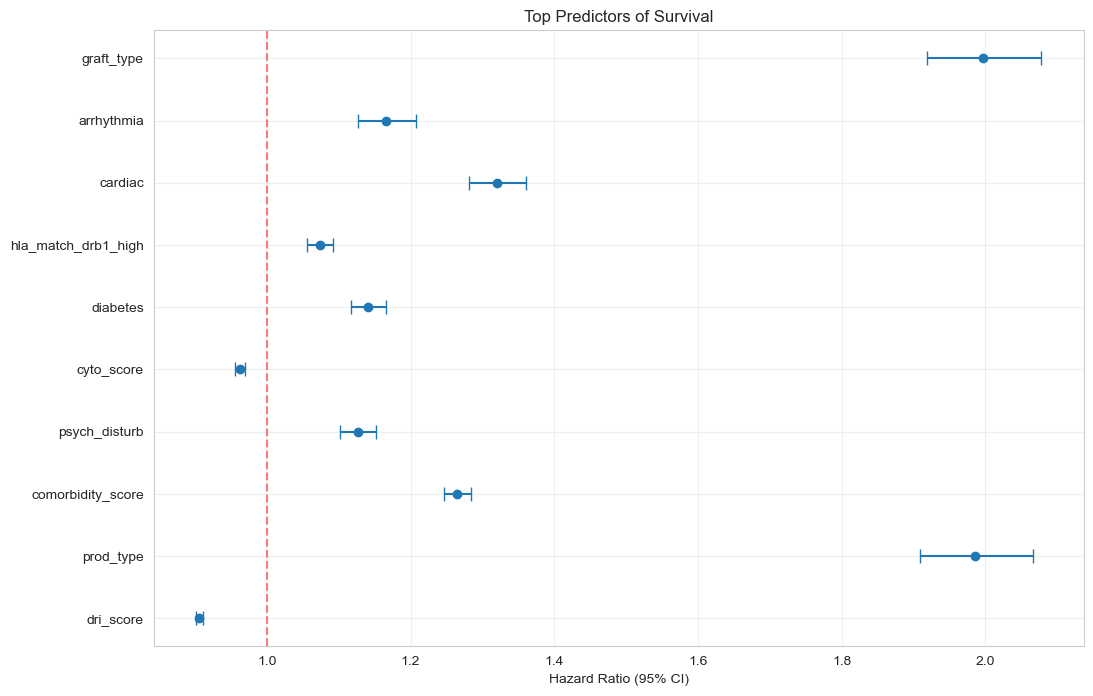

In [6]:
import matplotlib.pyplot as plt

# Run the complete analysis
results = run_complete_analysis(processed_df)

if results is not None:
    # Plot hazard ratios for significant predictors
    plot_hazard_ratios(results['univariate_results'])
    plt.show()

In [7]:
from sksurv.ensemble import RandomSurvivalForest
from tqdm.notebook import tqdm
import numpy as np
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

import time

def calculate_rsf_score_with_progress(rsf, X, y, batch_size=1000):
    """
    Calculate RSF score with progress tracking
    """
    total_samples = len(X)
    n_batches = (total_samples + batch_size - 1) // batch_size

    all_predictions = []
    print(f"\nProcessing {total_samples} samples in {n_batches} batches...")

    for i in tqdm(range(0, total_samples, batch_size), desc="Calculating predictions"):
        batch_end = min(i + batch_size, total_samples)
        X_batch = X.iloc[i:batch_end] if isinstance(X, pd.DataFrame) else X[i:batch_end]
        predictions_batch = rsf.predict(X_batch)
        all_predictions.extend(predictions_batch)

    print("Calculating final concordance index...")
    result = concordance_index_censored(
        y['event'],
        y['time'],
        -np.array(all_predictions)
    )[0]

    return result

'''
def calculate_feature_importance(model, X, y, n_repeats=5):
    """
    Calculate feature importance using permutation importance
    """
    print("Calculating permutation importance...")
    result = permutation_importance(
        model, X, y,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    })

    return importance_df.sort_values('importance_mean', ascending=False)

'''

def calculate_feature_importance(model, X, y, n_repeats=5):
    """
    Calculate feature importance using permutation importance with detailed progress
    """
    print(f"\nStarting permutation importance calculation:")
    print(f"- Number of features: {len(X.columns)}")
    print(f"- Number of repeats per feature: {n_repeats}")
    print(f"- Total permutations to calculate: {len(X.columns) * n_repeats}")

    start_time = time.time()

    print("\nCalculating baseline score...")
    baseline_score = model.score(X, y)
    print(f"Baseline score: {baseline_score:.4f}")

    print("\nStarting permutation importance calculation...")
    result = permutation_importance(
        model, X, y,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=-1
    )

    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    })

    # Sort by importance
    importance_df = importance_df.sort_values('importance_mean', ascending=False)

    total_time = time.time() - start_time
    print(f"\nPermutation importance calculation completed in {total_time:.2f} seconds")
    print("\nTop 10 most important features:")
    print(importance_df.head(10))

    return importance_df

def calculate_rsf_score_with_progress(rsf, X, y, batch_size=1000):
    """
    Calculate RSF score with progress tracking
    """
    total_samples = len(X)
    n_batches = (total_samples + batch_size - 1) // batch_size

    all_predictions = []
    print(f"\nProcessing {total_samples} samples in {n_batches} batches...")

    for i in tqdm(range(0, total_samples, batch_size), desc="Calculating predictions"):
        batch_end = min(i + batch_size, total_samples)
        X_batch = X.iloc[i:batch_end] if isinstance(X, pd.DataFrame) else X[i:batch_end]
        predictions_batch = rsf.predict(X_batch)
        all_predictions.extend(predictions_batch)

    print("Calculating final concordance index...")
    result = concordance_index_censored(
        y['event'],
        y['time'],
        -np.array(all_predictions)
    )[0]

    return result

def create_and_evaluate_models(df, significant_features, time_column='efs_time', event_column='efs'):
    """
    Creates and evaluates models with detailed progress tracking
    """
    print("Creating and evaluating survival models...")

    # Prepare data
    print("Preparing data...")
    start_time = time.time()
    X = df[significant_features]
    y = np.zeros(len(df), dtype=[('event', bool), ('time', float)])
    y['event'] = df[event_column].astype(bool)
    y['time'] = df[time_column]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create DataFrames for Cox model
    cox_train = pd.DataFrame(X_train, columns=significant_features)
    cox_train[time_column] = y_train['time']
    cox_train[event_column] = y_train['event']

    cox_test = pd.DataFrame(X_test, columns=significant_features)
    cox_test[time_column] = y_test['time']
    cox_test[event_column] = y_test['event']

    print(f"Data preparation completed in {time.time() - start_time:.2f} seconds")

    # Fit Cox model
    print("\nFitting Cox Proportional Hazards model...")
    start_time = time.time()
    cph = CoxPHFitter()
    cph.fit(cox_train, duration_col=time_column, event_col=event_column)
    print(f"Cox model fitting completed in {time.time() - start_time:.2f} seconds")

    # Calculate Cox predictions
    print("Calculating Cox predictions...")
    start_time = time.time()
    cox_test_pred = cph.predict_partial_hazard(cox_test)
    print(f"Cox predictions completed in {time.time() - start_time:.2f} seconds")

    # Fit Random Survival Forest
    print("\nFitting Random Survival Forest model...")
    start_time = time.time()
    rsf = RandomSurvivalForest(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=15,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    rsf.fit(X_train, y_train)
    print(f"RSF model fitting completed in {time.time() - start_time:.2f} seconds")

    # Evaluate models
    print("\nEvaluating models...")
    eval_start = time.time()

    print("Calculating Cox concordance indices...")
    start_time = time.time()
    cox_train_ci = cph.concordance_index_
    cox_test_ci = concordance_index_censored(
        cox_test[event_column].astype(bool),
        cox_test[time_column],
        -cox_test_pred
    )[0]
    print(f"Cox concordance calculation completed in {time.time() - start_time:.2f} seconds")

    print("\nCalculating RSF test score...")
    start_time = time.time()
    rsf_test_ci = calculate_rsf_score_with_progress(rsf, X_test, y_test)
    print(f"RSF test score completed in {time.time() - start_time:.2f} seconds")

    print("\nCalculating RSF train score...")
    start_time = time.time()
    rsf_train_ci = calculate_rsf_score_with_progress(rsf, X_train, y_train)
    print(f"RSF train score completed in {time.time() - start_time:.2f} seconds")

    # Calculate feature importance
    print("\nCalculating feature importance...")
    start_time = time.time()
    importance = calculate_feature_importance(rsf, X_test, y_test)
    print(f"Feature importance calculation completed in {time.time() - start_time:.2f} seconds")

    # Compile results
    results = {
        'cox_train_ci': cox_train_ci,
        'cox_test_ci': cox_test_ci,
        'rsf_train_ci': rsf_train_ci,
        'rsf_test_ci': rsf_test_ci
    }

    print(f"\nTotal evaluation time: {time.time() - eval_start:.2f} seconds")

    return {
        'cox_model': cph,
        'rsf_model': rsf,
        'metrics': results,
        'feature_importance': importance,
        'train_test_split': (X_train, X_test, y_train, y_test)
    }
    
def plot_model_results(models_dict):
    """
    Creates visualization of model results
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot feature importance from RSF
    plt.subplot(221)
    importance = models_dict['feature_importance']
    plt.barh(importance['feature'][:10], importance['importance'][:10])
    plt.title('Top 10 Important Features (RSF)')
    plt.xlabel('Importance Score')

    # Plot model comparison
    plt.subplot(222)
    metrics = models_dict['metrics']
    models = ['Cox (Train)', 'Cox (Test)', 'RSF (Train)', 'RSF (Test)']
    scores = [metrics['cox_train_ci'], metrics['cox_test_ci'],
              metrics['rsf_train_ci'], metrics['rsf_test_ci']]

    plt.barh(models, scores)
    plt.title('Model Concordance Index Comparison')
    plt.xlabel('Concordance Index')

    # Plot hazard ratios from Cox model
    plt.subplot(212)
    cox_summary = models_dict['cox_summary']
    top_features = cox_summary.sort_values('p_value').head(10)

    plt.errorbar(
        top_features['hazard_ratio'],
        range(len(top_features)),
        xerr=[top_features['hazard_ratio'] - top_features['lower_ci'],
              top_features['upper_ci'] - top_features['hazard_ratio']],
        fmt='o',
        capsize=5
    )
    plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
    plt.yticks(range(len(top_features)), top_features.index)
    plt.xlabel('Hazard Ratio (95% CI)')
    plt.title('Top 10 Significant Features (Cox Model)')

    plt.tight_layout()
    return plt

def plot_survival_curves(models_dict, df, time_column='efs_time', event_column='efs'):
    """
    Plots survival curves for both models
    """
    from lifelines import KaplanMeierFitter

    plt.figure(figsize=(15, 5))

    # Cox survival curves
    plt.subplot(121)
    risk_scores = models_dict['cox_model'].predict_partial_hazard(df)
    risk_groups = pd.qcut(risk_scores, q=3, labels=['Low', 'Medium', 'High'])

    kmf = KaplanMeierFitter()
    for group in ['Low', 'Medium', 'High']:
        mask = risk_groups == group
        kmf.fit(df[mask][time_column],
                df[mask][event_column].astype(bool),
                label=f'{group} Risk')
        kmf.plot()

    plt.title('Cox Model: Survival Curves by Risk Group')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')

    # RSF survival curves
    plt.subplot(122)
    X_test = models_dict['train_test_split'][1]
    predictions = models_dict['rsf_model'].predict_survival_function(X_test)

    for i in range(0, len(predictions), len(predictions)//3):
        plt.step(models_dict['rsf_model'].event_times_, predictions[i],
                 where="post", alpha=0.1)

    plt.title('RSF Model: Individual Survival Curves')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')

    plt.tight_layout()
    return plt

In [ ]:
# Let's also add some information about your data size
significant_features = results['significant_features']


print(f"Dataset size: {len(processed_df)} samples")
print(f"Number of features: {len(significant_features)}")

# Create and evaluate models with progress monitoring
model_results = create_and_evaluate_models(processed_df, significant_features)

Dataset size: 28800 samples
Number of features: 45
Creating and evaluating survival models...
Preparing data...
Data preparation completed in 0.02 seconds

Fitting Cox Proportional Hazards model...
Cox model fitting completed in 3.17 seconds
Calculating Cox predictions...
Cox predictions completed in 0.01 seconds

Fitting Random Survival Forest model...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


RSF model fitting completed in 88.94 seconds

Evaluating models...
Calculating Cox concordance indices...
Cox concordance calculation completed in 0.38 seconds

Calculating RSF test score...

Processing 5760 samples in 6 batches...


Calculating predictions:   0%|          | 0/6 [00:00<?, ?it/s]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   19.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   17.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_job

In [11]:
# Assuming 'results' contains your univariate analysis results
if results is not None:
    # Get significant features
    significant_features = results['significant_features']

    # Create and evaluate models
    #model_results = create_and_evaluate_models(processed_df, significant_features)

    # Print evaluation metrics
    print("\nModel Performance Metrics:")
    for metric, value in model_results['metrics'].items():
        print(f"{metric}: {value:.3f}")

    # Print top features
    print("\nTop 10 Important Features (Random Survival Forest):")
    print(model_results['feature_importance'].head(10))

    # Plot results
    plot_model_results(model_results)
    plt.show()

    # Plot survival curves
    from lifelines import KaplanMeierFitter
    plot_survival_curves(model_results, processed_df)
    plt.show()


Model Performance Metrics:


NameError: name 'model_results' is not defined

In [ ]:
import joblib
import pickle
import os
from datetime import datetime

def save_models(model_results, base_path='models'):
    """
    Saves the trained models and their results
    
    Parameters:
    model_results: dict containing models and their metrics
    base_path: directory to save the models
    """
    # Create directory if it doesn't exist
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Create timestamp for unique naming
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save Random Survival Forest model
    rsf_filename = os.path.join(base_path, f'rsf_model_{timestamp}.joblib')
    joblib.dump(model_results['rsf_model'], rsf_filename)
    print(f"Saved RSF model to: {rsf_filename}")

    # Save Cox model
    cox_filename = os.path.join(base_path, f'cox_model_{timestamp}.pkl')
    with open(cox_filename, 'wb') as f:
        pickle.dump(model_results['cox_model'], f)
    print(f"Saved Cox model to: {cox_filename}")

    # Save feature importance and metrics
    results_filename = os.path.join(base_path, f'model_results_{timestamp}.pkl')
    results_to_save = {
        'metrics': model_results['metrics'],
        'feature_importance': model_results['feature_importance']
    }
    with open(results_filename, 'wb') as f:
        pickle.dump(results_to_save, f)
    print(f"Saved model results to: {results_filename}")

    return {
        'rsf_path': rsf_filename,
        'cox_path': cox_filename,
        'results_path': results_filename
    }

def load_models(model_paths):
    """
    Loads the saved models and their results
    
    Parameters:
    model_paths: dict containing paths to saved models
    """
    # Load Random Survival Forest model
    rsf_model = joblib.load(model_paths['rsf_path'])
    print(f"Loaded RSF model from: {model_paths['rsf_path']}")

    # Load Cox model
    with open(model_paths['cox_path'], 'rb') as f:
        cox_model = pickle.load(f)
    print(f"Loaded Cox model from: {model_paths['cox_path']}")

    # Load results
    with open(model_paths['results_path'], 'rb') as f:
        results = pickle.load(f)
    print(f"Loaded model results from: {model_paths['results_path']}")

    return {
        'rsf_model': rsf_model,
        'cox_model': cox_model,
        'metrics': results['metrics'],
        'feature_importance': results['feature_importance']
    }

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def prepare_test_data(test_df, train_df, significant_features):
    """
    Prepares test data using the same preprocessing as training data
    
    Parameters:
    test_df: DataFrame containing test data
    train_df: DataFrame containing training data (for fitting preprocessors)
    significant_features: list of features to use
    """
    print("Preparing test data...")

    # Create copy of test data
    processed_test = test_df.copy()

    # Separate numerical and categorical columns
    numeric_features = [f for f in significant_features
                        if train_df[f].dtype in ['float64', 'int64']]
    categorical_features = [f for f in significant_features
                            if train_df[f].dtype == 'object']

    # Handle missing values
    for feature in numeric_features:
        if feature in processed_test.columns:
            median_value = train_df[feature].median()
            processed_test[feature].fillna(median_value, inplace=True)

    for feature in categorical_features:
        if feature in processed_test.columns:
            mode_value = train_df[feature].mode()[0]
            processed_test[feature].fillna(mode_value, inplace=True)

    # Encode categorical variables
    for feature in categorical_features:
        if feature in processed_test.columns:
            # Get unique values from both train and test
            all_values = pd.concat([train_df[feature], processed_test[feature]]).unique()
            value_map = {val: idx for idx, val in enumerate(all_values)}
            processed_test[feature] = processed_test[feature].map(value_map)

    # Scale numeric features
    scaler = StandardScaler()
    for feature in numeric_features:
        if feature in processed_test.columns:
            # Fit on training data
            scaler.fit(train_df[[feature]])
            # Transform test data
            processed_test[feature] = scaler.transform(processed_test[[feature]])

    return processed_test[significant_features]

def generate_predictions(model_results, test_df, train_df, output_path='submission.csv'):
    """
    Generates predictions for test data and saves them in the required format
    
    Parameters:
    model_results: dict containing trained models and their information
    test_df: DataFrame containing test data
    train_df: DataFrame containing training data (for preprocessing)
    output_path: path to save the predictions
    """
    print("Generating predictions...")

    # Get significant features from model results
    significant_features = model_results['feature_importance']['feature'].tolist()

    # Prepare test data
    processed_test = prepare_test_data(test_df, train_df, significant_features)

    # Generate predictions using RSF model (could also use Cox model if preferred)
    rsf_model = model_results['rsf_model']
    predictions = rsf_model.predict_survival_function(processed_test)

    # Convert survival function predictions to risk scores
    # Higher risk score = lower survival probability
    risk_scores = np.array([1 - func(func.x.mean()) for func in predictions])

    # Scale predictions to [0,1] range
    scaled_predictions = (risk_scores - risk_scores.min()) / (risk_scores.max() - risk_scores.min())

    # Create submission DataFrame
    submission = pd.DataFrame({
        'ID': test_df['ID'],
        'prediction': scaled_predictions
    })

    # Save predictions
    submission.to_csv(output_path, index=False)
    print(f"Saved predictions to: {output_path}")

    return submission

In [ ]:
# Load test data
test_df = pd.read_csv(DATA_DIR +'test.csv')

# Generate predictions
predictions = generate_predictions(
    model_results=model_results,
    test_df=test_df,
    train_df=processed_df,  # Your original training data
    output_path='submission.csv'
)

# Display first few predictions
print("\nFirst few predictions:")
print(predictions.head())